# 2025 CVE Time Series Forecasting using Kalman Filter

Backgound on the Kalman Filter:
https://en.wikipedia.org/wiki/Kalman_filter 

Python Library Used: 
https://unit8co.github.io/darts/

In [1]:
from IPython.display import Markdown
from datetime import date
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import KalmanForecaster

/opt/hostedtoolcache/Python/3.12.11/x64/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


In [2]:


def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
pastdata = ((nvd['Published'] > '2017-01-01') & (nvd['Published']  < '2025-01-01'))
thisyear = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2026-01-01'))
nvd_2024 = nvd.loc[thisyear]
nvd = nvd.loc[pastdata]
startdate = date(2017, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [3]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **194461**<br />Average CVEs Per Day: **96.68**<br />Average CVSS Score: **6.91**

In [4]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Published'] = nvd['Published'].dt.to_period('M').dt.to_timestamp()  # Normalize to start of the month
monthly = nvd['Published'].groupby(nvd.Published).agg('count')
monthly_cves = pd.DataFrame(monthly)
monthly_cves.columns = ['Count']
monthly_cves = monthly_cves .reset_index()
monthly_cves = monthly_cves.rename(columns={"Published" : "Month" ,"Count": "CVEs"})
monthly_cves['Month'] = monthly_cves['Month'].astype(str)
monthly_cves['Month'] = pd.to_datetime(monthly_cves['Month'])

<Axes: xlabel='Month'>

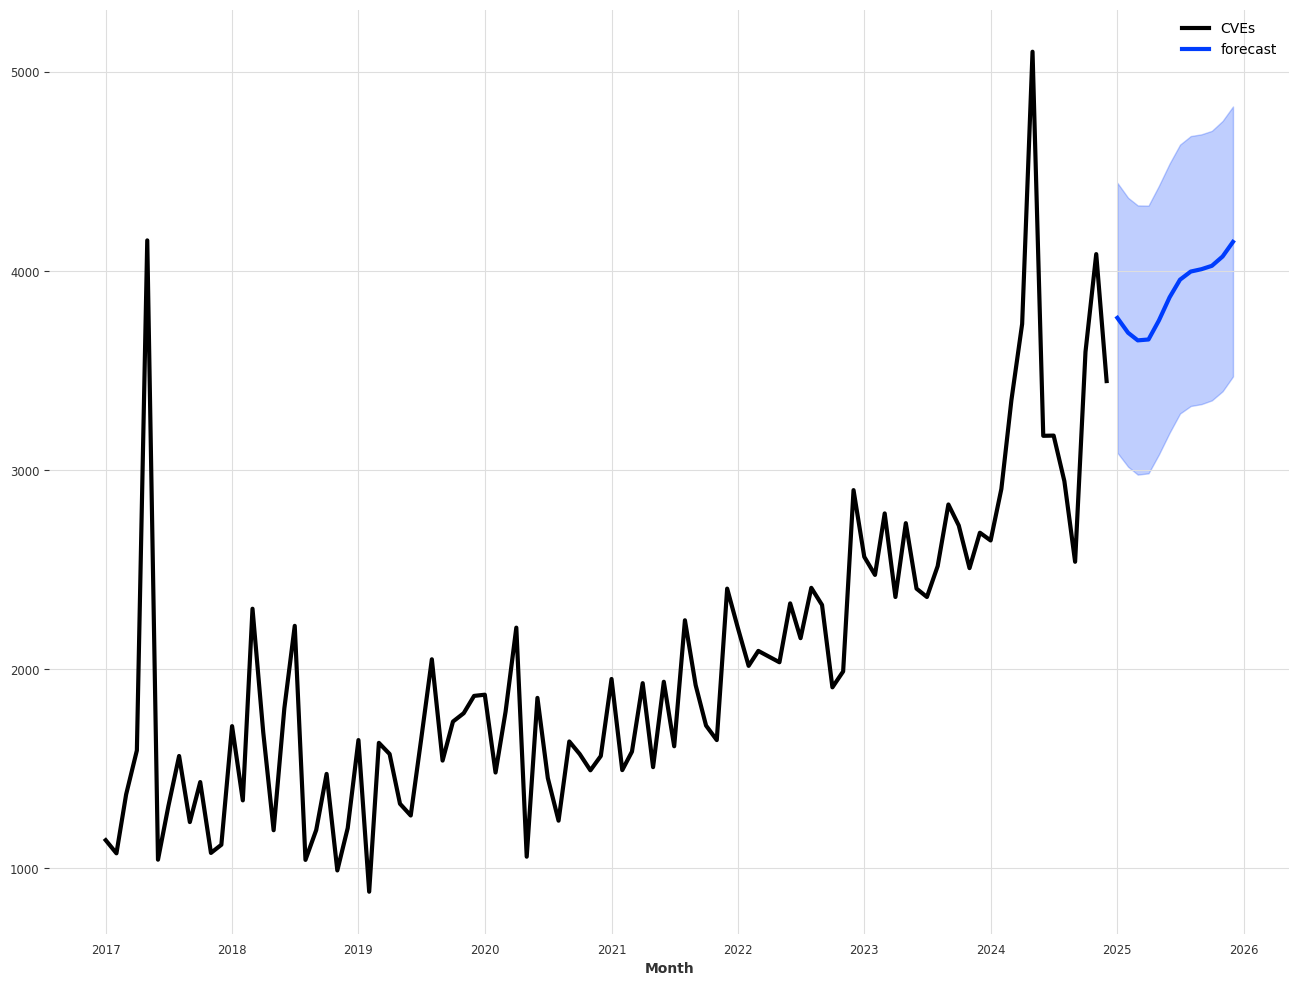

In [5]:
train = TimeSeries.from_dataframe(monthly_cves,"Month", "CVEs")
model = KalmanForecaster(dim_x=4)
model.fit(train)
pred = model.predict(n=12, num_samples=100000)

plt.figure(figsize=(16,12))
train.plot(lw=3)
pred.plot(lw=3, label='forecast')

In [6]:
# Use quantile_df() to handle stochastic TimeSeries if you want a specific quantile
darts_df = pred.quantile_df(quantile=0.5)  # Example: Use the median (50th percentile)

# Process the DataFrame as before
darts_monthly = darts_df.mean(axis=1).round(0)
darts_monthly = darts_monthly.to_frame()
darts_monthly = darts_monthly.reset_index()
darts_monthly = darts_monthly.rename(columns={0: "CVEs Predicted"})
darts_monthly['Month'] = darts_monthly['Month'].dt.month_name()
darts_monthly

,Month,CVEs Predicted
0,January,3766.0
1,February,3691.0
2,March,3653.0
3,April,3657.0
4,May,3752.0
5,June,3869.0
6,July,3958.0
7,August,3998.0
8,September,4010.0
9,October,4027.0


In [7]:
darts_monthly['CVEs Predicted'].sum()

np.float64(46602.0)

In [8]:
monthly_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
monthly_cves_2024 = pd.DataFrame(monthly_2024)
monthly_cves_2024.columns = ['Count']
monthly_cves_2024 = monthly_cves_2024.reset_index()
monthly_cves_2024 = monthly_cves_2024.rename(columns={"Published" : "Month" ,"Count": "CVEs Actual"})
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].astype(str)
monthly_cves_2024['Month'] = pd.to_datetime(monthly_cves_2024['Month'])
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].dt.month_name()
monthly_cves_2024

,Month,CVEs Actual
0,January,4415
1,February,3831
2,March,4166
3,April,4142
4,May,4264
5,June,3685


In [9]:
validation_df = pd.merge(
    monthly_cves_2024,
    darts_monthly,
    how="outer",
    on='Month',
)

month_categories = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December', 'Total']

validation_df['Month'] = pd.Categorical(validation_df['Month'], categories = month_categories, ordered = True)
validation_df = validation_df.sort_values(by='Month')


validation_df

,Month,CVEs Actual,CVEs Predicted
4,January,4415.0,3766.0
3,February,3831.0,3691.0
7,March,4166.0,3653.0
0,April,4142.0,3657.0
8,May,4264.0,3752.0
6,June,3685.0,3869.0
5,July,NaN,3958.0
1,August,NaN,3998.0
11,September,NaN,4010.0
10,October,NaN,4027.0


In [10]:
# Fix SettingWithCopyWarning by using .loc
validation_df['Difference'] = validation_df['CVEs Actual'] - validation_df['CVEs Predicted']

# Replace inplace=True with assignment to avoid FutureWarning
validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)

validation_df['Difference'] = validation_df['CVEs Actual'] -  validation_df['CVEs Predicted'] 

numeric_df = validation_df.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)

validation_df = pd.concat([validation_df, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)
validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)

In [11]:

def percentage_change(col1,col2):
    return ((col2 / col1) * 100).round(0)

validation_df['Precentage'] = percentage_change(validation_df['CVEs Predicted'],validation_df['CVEs Actual'])   

validation_df['Precentage'] = validation_df['Precentage'].fillna(0)
validation_df.at[12,'Month']='Total'



In [12]:
darts_total = darts_monthly.copy()

darts_total.fillna(0) 
numeric_df = darts_total.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)
darts_total = pd.concat([darts_total, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)

darts_total.at[12,'Month']='Total'
darts_total

,Month,CVEs Predicted
0,January,3766.0
1,February,3691.0
2,March,3653.0
3,April,3657.0
4,May,3752.0
5,June,3869.0
6,July,3958.0
7,August,3998.0
8,September,4010.0
9,October,4027.0


In [13]:
validation_df['CVEs Actual'] = validation_df['CVEs Actual'].fillna(0)
validation_df['Difference'] = validation_df['Difference'].fillna(0)
validation_df['Precentage'] = validation_df['Precentage'].fillna(0)
validation_df

,Month,CVEs Actual,CVEs Predicted,Difference,Precentage
0,January,4415.0,3766.0,649.0,117.0
1,February,3831.0,3691.0,140.0,104.0
2,March,4166.0,3653.0,513.0,114.0
3,April,4142.0,3657.0,485.0,113.0
4,May,4264.0,3752.0,512.0,114.0
5,June,3685.0,3869.0,-184.0,95.0
6,July,0.0,3958.0,-3958.0,0.0
7,August,0.0,3998.0,-3998.0,0.0
8,September,0.0,4010.0,-4010.0,0.0
9,October,0.0,4027.0,-4027.0,0.0
